In [1]:
from sklearn.datasets import make_circles, make_moons
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from sklearn.model_selection import train_test_split
from cvxopt import matrix
from cvxopt import solvers
from numpy import linalg as LA

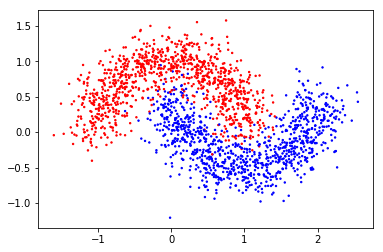

In [2]:
X, y = make_moons(n_samples=2000, noise=0.2)
colors = ['red','blue']
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=matplotlib.colors.ListedColormap(colors), s=2)
y[y == 0] = -1
seed = 1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

## MCMC sampling method

In [3]:
def metropolis_hastings(p, dim, iter=1000):
    x = np.zeros(dim)
    samples = np.zeros((iter, dim))

    for i in range(iter):
        x_next = x + np.random.multivariate_normal(np.zeros(dim), np.eye(dim))
        if np.random.rand() < p(x_next) / p(x):
            x = x_next
        samples[i] = x

    return samples

In [4]:
def p(delta):
    if delta < 0.:
        return 0.
    else:
        return delta * np.exp(-delta)

In [5]:
def one_hot(dim, pos):
    vec = np.zeros(int(dim))
    vec[int(pos)] = 1.
    return vec

## calculate the span of the gird in each direction

In [6]:
spans = np.zeros(X_train.shape[-1])
for i in range(X_train.shape[-1]):
    spans[i] = np.max(X_train[:, i]) - np.min(X_train[:, i])

## computer feature map

In [7]:
max_iter = 1000
P = 30
d = 2
deltas = np.zeros((P, d))
us = np.zeros((P, d))
num_of_bins_collect = []

# draw grid parameters
for i in range(P):
    s = metropolis_hastings(p, 1, iter=max_iter)
    delta = s[np.random.randint(low=20, high=max_iter, size=d)]
    u =  np.random.uniform(low=0, high=delta)
    delta = delta.reshape(delta.shape[0])
    u = u.reshape(u.shape[0])
    deltas[i, :] = delta
    us[i, :] = u
    num_of_bins = (np.ceil((spans) / delta)).astype("int") + 1
    num_of_bins_collect.append(num_of_bins)

X_train_map = []
lower = np.min(X_train, axis=0)

for i in range(X_train.shape[0]):
    x = X_train[i]
    X_map = []
    
    for j in range(P):
        bin_idx = (np.ceil((x - lower - us[j, :]) / deltas[j, :])).astype("int")
        X_map.append(np.array([np.sqrt(1/P) * one_hot(dim, pos) for dim, pos in zip(num_of_bins_collect[j], bin_idx)]))
        
    X_train_map.append(X_map)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys


## function to computer the dot product between the one-hot grids

In [8]:
def dot_product(x1, x2):
    s = 0
    for i in range(len(x1)):
        for j in range(x1[i].shape[0]):
            s += np.dot(x1[i][j], x2[i][j])
    return s

## compute the gram matrix

In [9]:
taille = len(X_train_map)
K = np.zeros((taille, taille))
for i in range(taille):
    for j in range(taille):
        K[i, j] = dot_product(X_train_map[i], X_train_map[j])
K

array([[2.        , 1.03333333, 0.43333333, ..., 1.56666667, 0.46666667,
        1.03333333],
       [1.03333333, 2.        , 0.86666667, ..., 0.96666667, 0.8       ,
        0.73333333],
       [0.43333333, 0.86666667, 2.        , ..., 0.46666667, 0.76666667,
        0.36666667],
       ...,
       [1.56666667, 0.96666667, 0.46666667, ..., 2.        , 0.63333333,
        1.26666667],
       [0.46666667, 0.8       , 0.76666667, ..., 0.63333333, 2.        ,
        1.23333333],
       [1.03333333, 0.73333333, 0.36666667, ..., 1.26666667, 1.23333333,
        2.        ]])

## QP solver for the linear kernel

In [10]:
m = K.shape[0]
y_train = y_train.reshape(-1,1) * 1.
H = np.outer(y_train, y_train) * K
H.shape

C = 10
P = matrix(H)
q = matrix(-np.ones(m))
G = matrix(np.vstack((np.eye(m)*-1,np.eye(m))))
h = matrix(np.hstack((np.zeros(m), np.ones(m) * C)))
A = matrix(y_train, (1, m))
b = matrix(0.)

#Run solver
sol = solvers.qp(P, q, G, h, A, b)
alphas = np.array(sol['x'])

alphas = alphas.reshape(alphas.shape[0])

sup_vec_idx = np.argwhere(np.logical_or(alphas > 1e-4, alphas < -1e-4))
sup_vec_idx = sup_vec_idx.reshape(sup_vec_idx.shape[0])
X_sup_vec = X_train[sup_vec_idx]
y_sup_vec = y_train[sup_vec_idx]
alphas_sup_vec = alphas[sup_vec_idx]

     pcost       dcost       gap    pres   dres
 0: -1.4625e+03 -1.2026e+05  3e+05  9e-01  8e-14
 1: -1.8181e+02 -3.7078e+04  6e+04  1e-01  1e-13
 2: -1.1355e+01 -9.5019e+03  1e+04  2e-02  8e-14
 3: -4.6298e+02 -3.5210e+03  3e+03  4e-03  9e-14
 4: -7.0450e+02 -2.3260e+03  2e+03  1e-03  1e-13
 5: -8.5202e+02 -1.6048e+03  8e+02  2e-04  1e-13
 6: -9.5625e+02 -1.3054e+03  4e+02  5e-05  1e-13
 7: -9.8888e+02 -1.2154e+03  2e+02  3e-05  1e-13
 8: -1.0208e+03 -1.1322e+03  1e+02  1e-05  1e-13
 9: -1.0392e+03 -1.0817e+03  4e+01  9e-14  2e-13
10: -1.0487e+03 -1.0665e+03  2e+01  9e-14  2e-13
11: -1.0522e+03 -1.0613e+03  9e+00  1e-14  1e-13
12: -1.0546e+03 -1.0579e+03  3e+00  1e-13  2e-13
13: -1.0560e+03 -1.0561e+03  2e-01  3e-13  2e-13
14: -1.0560e+03 -1.0560e+03  3e-03  2e-13  2e-13
15: -1.0560e+03 -1.0560e+03  6e-05  4e-14  2e-13
Optimal solution found.


In [11]:
sup_vec_idx.shape

(212,)

## transform test data

In [12]:
X_test_map = []
lower = np.min(X_test, axis=0)
P = 30

for i in range(X_test.shape[0]):
    x = X_test[i]
    X_map = []
    
    for j in range(P):
        bin_idx = (np.ceil((x - lower - us[j, :]) / deltas[j, :])).astype("int")
        X_map.append(np.array([np.sqrt(1/P) * one_hot(dim, pos) for dim, pos in zip(num_of_bins_collect[j], bin_idx)]))
        
    X_test_map.append(X_map)

## calculate weight and bias

In [13]:
weights = []
for i in range(P):
    temp = []
    for j in range(len(X_train_map[0][i])):
        temp.append(np.zeros(X_train_map[0][i][j].shape))
    weights.append(np.array(temp))
    
for idx in sup_vec_idx:
    for j in range(P):
        weights[j] += X_train_map[idx][j] * y_train[idx] * alphas[idx]

In [14]:
y_train = y_train.reshape(y_train.shape[0])
minus_idx = (np.argwhere(y_train == -1)).squeeze()
max_val = -np.inf
for i in minus_idx:
    val = dot_product(X_train_map[i], weights)
    if val > max_val:
        max_val = val

plus_idx = (np.argwhere(y_train == 1)).squeeze()
min_val = np.inf
for i in plus_idx:
    val = dot_product(X_train_map[i], weights)
    if val < min_val:
        min_val = val

bias = - (max_val + min_val) / 2
bias

-0.6220276510434563

In [15]:
pred = []
for x in X_test_map:
    pred.append(np.sign(dot_product(x, weights) + bias))
pred = np.array(pred)

## test set accuracy

In [16]:
np.sum((pred == y_test).astype("int")) / y_test.shape[0]

0.9375

## visualizing support vectors

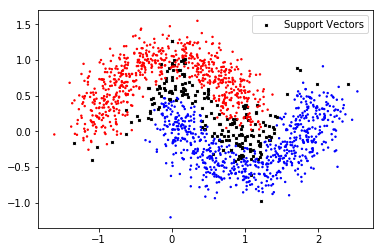

In [17]:
X_sup_vec = X_train[sup_vec_idx]
X_non_sup_vec = X_train[~np.isin(np.arange(len(X_train)), sup_vec_idx)]
y_non_sup_vec = y_train[~np.isin(np.arange(len(y_train)), sup_vec_idx)]
y_non_sup_vec = y_non_sup_vec.reshape(y_non_sup_vec.shape[0])
fig, ax = plt.subplots()
colors = ['red','blue']
ax.scatter(X_sup_vec[:, 0], X_sup_vec[:, 1], c="black", s=6, marker='x', label="Support Vectors")
ax.scatter(X_non_sup_vec[:, 0], X_non_sup_vec[:, 1], c=y_non_sup_vec, cmap=matplotlib.colors.ListedColormap(colors), s=2)
ax.legend(loc="upper right")
plt.show()